<a href='http://www.zappistore.com'> <img src='../zappi-store.png' /></a>

                               
# OWASP MEETUP 
## CAPE TOWN CHAPTER

## by Hatitye (Hati) Chindove

### Question: 
#### Which attackers should we take on to address the concerns regarding information confidentiality and integrity on our network?

#### Pre-requisites:
1. Query data on Athena for VPC flow logs (ideally with action 'ACCEPT') and save in R/data/small_flow_log.csv
- Achievable in code using simba jdbc connector or an R library called RJDBC

Sample query in athena for flow logs

`
SELECT current_date AS query_time ,
        interfaceid,
         sourceaddress,
         destinationaddress,
         sourceport,
         destinationport,
         protocol,
         date(from_unixtime(starttime))as start_time,
         action
FROM "data_lake_store"."kubernetes_vpc_flow_logs"
WHERE action like 'ACCEPT' LIMIT 1000000;
`

### 1. Download and load flow log data for analysis

```
VPC flow logs can help you track and understand traffic to and from your VPC, a subnet, or a network interface. One can potentially create relations between the network traffic and the instances running on the network. 

```

In [1]:
flow_logs <- read.csv("data/small_flow_log.csv",header=TRUE)

In [2]:
colnames(flow_logs) <- c("EXPORT_TIME","INTERFACE_ID","SOURCE_IP","DESTINATION_IP","SOURCE_PORT","DESTINATION_PORT","PROTOCOL","REQUEST_TIME","LOG_ACTION")

In [3]:
head(flow_logs)

EXPORT_TIME,INTERFACE_ID,SOURCE_IP,DESTINATION_IP,SOURCE_PORT,DESTINATION_PORT,PROTOCOL,REQUEST_TIME,LOG_ACTION
2018-03-19,eni-5f99fb93,10.80.38.70,10.80.107.209,38242,6784,17,2018-02-24,ACCEPT
2018-03-19,eni-5f99fb93,10.80.38.70,10.80.107.209,49815,6784,17,2018-02-24,ACCEPT
2018-03-19,eni-5f99fb93,10.80.78.127,10.80.107.209,58685,6784,17,2018-02-24,ACCEPT
2018-03-19,eni-5f99fb93,10.80.107.209,10.80.42.60,39545,6784,17,2018-02-24,ACCEPT
2018-03-19,eni-5f99fb93,10.80.107.209,10.80.74.130,48796,6784,17,2018-02-24,ACCEPT
2018-03-19,eni-5f99fb93,10.80.107.209,10.80.42.60,45108,6784,17,2018-02-24,ACCEPT


### 2. Download open reputation data set and load data set for analysis

```
Alien vault reputational data are a result of open source threat intelligence feeds which rely on community involved and can reflect a varying degree of accuracy for action. In order to evaluate a reputational IP it is essential to take not of the context of the IP through understanding the reliability of record, risk rating of the record and the type of host the record/IP has been identified as. Based of this, decisions can be make on the next actions to make against an IP. A number of factors have be accounted for when taking action against an information found from Open Source Threat Intelligence feeds.
```

In [4]:
source_url <- "https://reputation.alienvault.com/reputation.data"

In [5]:
destination_url <- "data/reputation.data"

In [6]:
download.file(source_url, destination_url)

In [7]:
reputations <- read.csv(destination_url,sep="#",header=FALSE)

In [8]:
colnames(reputations) <- c("IP", "Reliability", "Risk", "Type", "Country", "Locale", "Coords", "x")

In [9]:
head(reputations)

IP,Reliability,Risk,Type,Country,Locale,Coords,x
2.50.14.159,4,2,Malicious Host,AE,Dubai,"25.2581996918,55.3046989441",3
1.34.85.100,4,2,Malicious Host,TW,,"23.5,121.0",3
5.188.9.30,4,2,Malicious Host,RU,Saint Petersburg,"59.8944015503,30.2642002106",3
14.136.81.28,4,2,Malicious Host,HK,Central District,"22.2833003998,114.150001526",3
14.136.49.221,4,2,Malicious Host,HK,Tuen Mun,"22.3999996185,113.983299255",3
14.134.180.8,4,2,Malicious Host,CN,Yinchuan,"38.4681015015,106.273101807",3


In [10]:
request_set <- merge(flow_logs,reputations, by.x = "SOURCE_IP", by.y = "IP")

### 3. Create an intecept of relevant analysis data

- Potential Malicious Requests

In [11]:
summary(request_set$LOG_ACTION)

- ACCEPT REJECT 
     0    102    633

In [12]:
response_set <- merge(flow_logs,reputations, by.x = "DESTINATION_IP", by.y = "IP")

- Potential Data Leaks from potential malicious requests

In [13]:
summary(response_set$LOG_ACTION)

- ACCEPT REJECT 
     0     22      0

### 4. Analysis of inbound requests

In [14]:
library(lattice)

In [15]:
inbound.tab <- xtabs(~Risk+Reliability, data=request_set)

In [16]:
inbound.df = data.frame(table(request_set$Risk, request_set$Reliability))

In [17]:
colnames(inbound.df) <- c("Risk", "Reliability", "Freq")

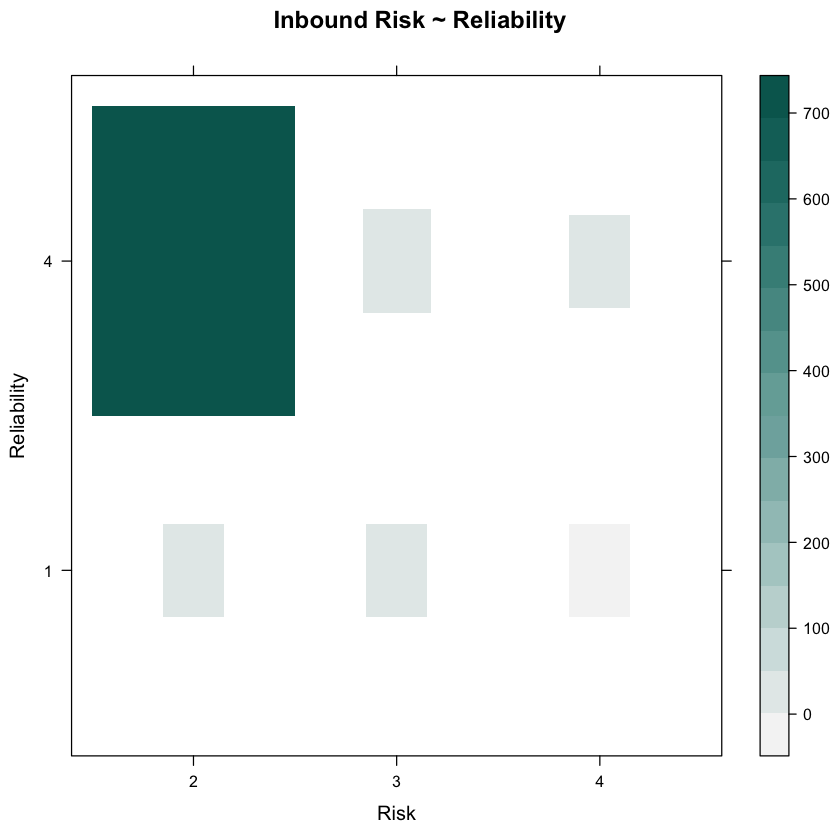

In [18]:
levelplot(Freq~Risk*Reliability, data=inbound.df, main="Inbound Risk ~ Reliability", ylab="Reliability", xlab="Risk", 
          shrink = c(0.3, 1),col.regions = colorRampPalette(c("#F5F5F5", "#01665E"))(30))

#### 4.1. Analysis of inbound traffic categorised by type of host

In [19]:
request_set$simpletype <- as.character(request_set$Type)

In [20]:
request_set$simpletype[grep(';', request_set$simpletype)] <- "Multiples"

In [21]:
request_set$simpletype <- factor(request_set$simpletype)

In [22]:
inbound_table.df = data.frame(table(request_set$Risk, request_set$Reliability, request_set$simpletype))

In [23]:
colnames(inbound_table.df) <- c("Risk", "Reliability", "simpletype", "Freq")

In [24]:
inbound_table.df

Risk,Reliability,simpletype,Freq
2,1,Malicious Host,2
3,1,Malicious Host,2
4,1,Malicious Host,0
2,4,Malicious Host,695
3,4,Malicious Host,35
4,4,Malicious Host,1


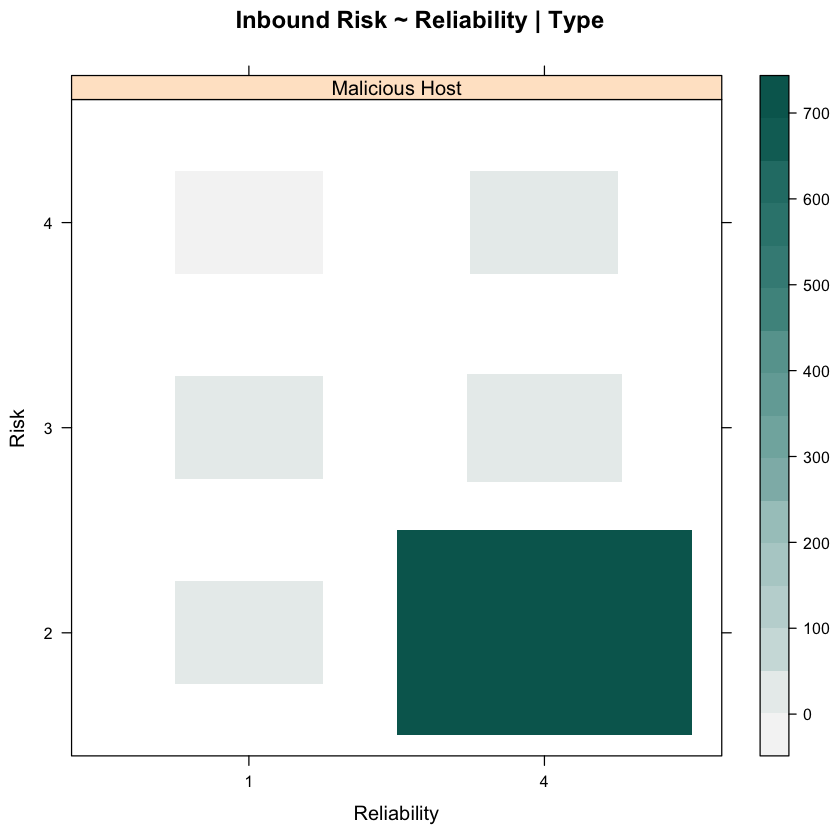

In [25]:
levelplot(Freq ~ Reliability*Risk|simpletype, data = inbound_table.df, 
         main="Inbound Risk ~ Reliability | Type", ylab = "Risk",
         xlab = "Reliability", shrink = c(0.5, 1),
         col.regions = colorRampPalette(c("#F5F5F5", "#01665E"))(20))

#### 4.2. Map areas of inbound malicious host activity

In [26]:
library(maps)
library(RColorBrewer)
library(scales)
library(ggplot2)

In [27]:
request_set.coords.vec <- unlist(strsplit(as.character(request_set$Coords), ","))

In [28]:
request_set.coords.mat <- matrix(request_set.coords.vec,ncol=2, byrow=TRUE)

In [29]:
request_set.coords.df <- as.data.frame(request_set.coords.mat)

In [30]:
colnames(request_set.coords.df) <- c("lat","long")

In [31]:
request_set.coords.df$long <- as.double(as.character(request_set.coords.df$long))

In [32]:
request_set.coords.df$lat <- as.double(as.character(request_set.coords.df$lat))

In [33]:
set2 <- brewer.pal(8,"Set2")

In [34]:
world <- map_data('world')

In [35]:
gg <- ggplot()

In [36]:
gg <- gg + geom_polygon(data = world, aes(long, lat, group=group), 
                        fill = "white", colour="black")

In [37]:
gg <- gg + geom_point(data=request_set.coords.df, aes(x=long, y=lat),
                color=set2[2],size=1, alpha=0.1)

In [38]:
gg <- gg + labs(x="", y="")

In [39]:
gg <- gg + theme(panel.background = element_rect(fill = alpha(set2[3],0.4)))

#### Global distribution of inbound reputation

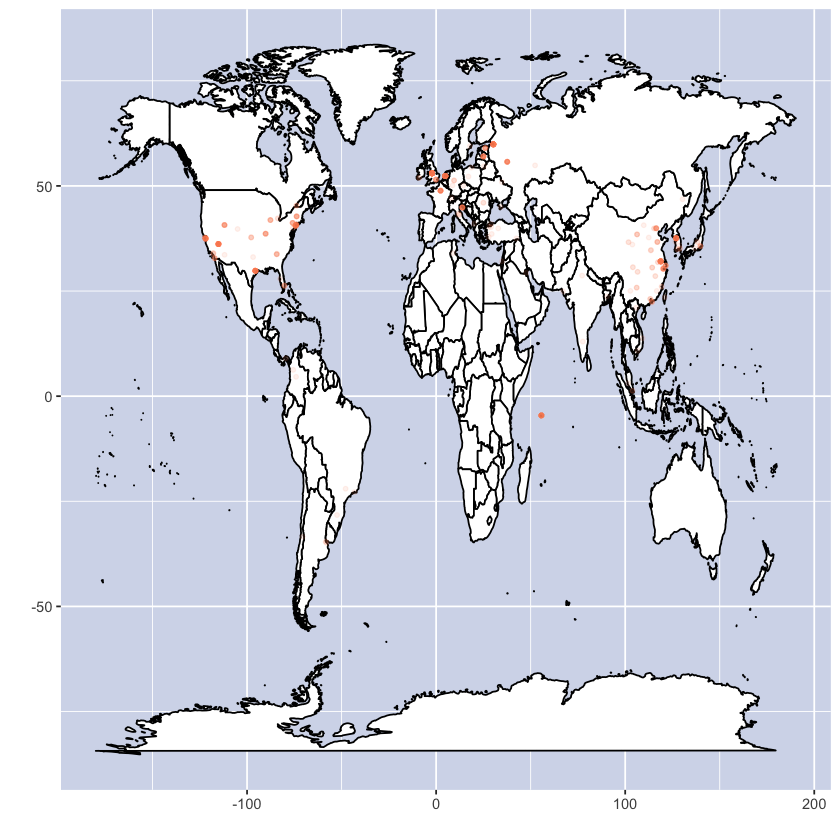

In [40]:
gg

### 5. Analysis of outbound requests

In [41]:
outbound.tab <- xtabs(~Risk+Reliability, data=response_set)

In [42]:
outbound.df = data.frame(table(response_set$Risk, response_set$Reliability))

In [43]:
colnames(outbound.df) <- c("Risk", "Reliability", "Freq")

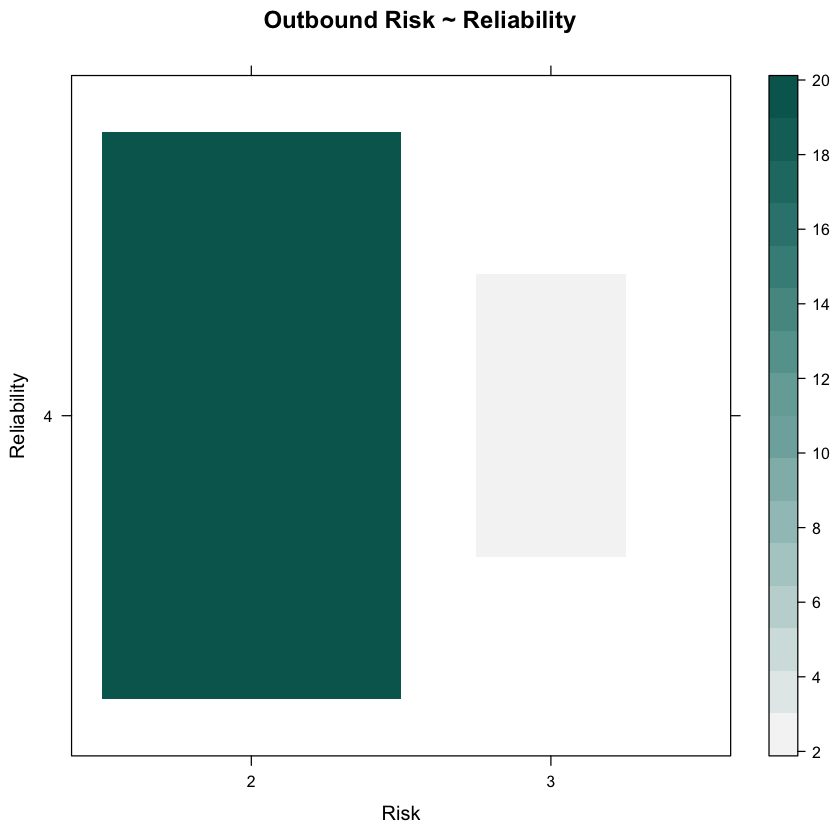

In [44]:
levelplot(Freq~Risk*Reliability, data=outbound.df, main="Outbound Risk ~ Reliability", ylab="Reliability", xlab="Risk", 
          shrink = c(0.5, 1),col.regions = colorRampPalette(c("#F5F5F5", "#01665E"))(30))

#### 5.1. Analysis of outbound traffic categorised by type of host


In [45]:
response_set$simpletype <- as.character(response_set$Type)

In [46]:
response_set$simpletype[grep(';', response_set$simpletype)] <- "Multiples"

In [47]:
response_set$simpletype <- factor(response_set$simpletype)

In [48]:
outbound_table.df = data.frame(table(response_set$Risk, response_set$Reliability, response_set$simpletype))

In [49]:
colnames(outbound_table.df) <- c("Risk", "Reliability", "simpletype", "Freq")

In [50]:
outbound_table.df

Risk,Reliability,simpletype,Freq
2,4,Malicious Host,19
3,4,Malicious Host,3


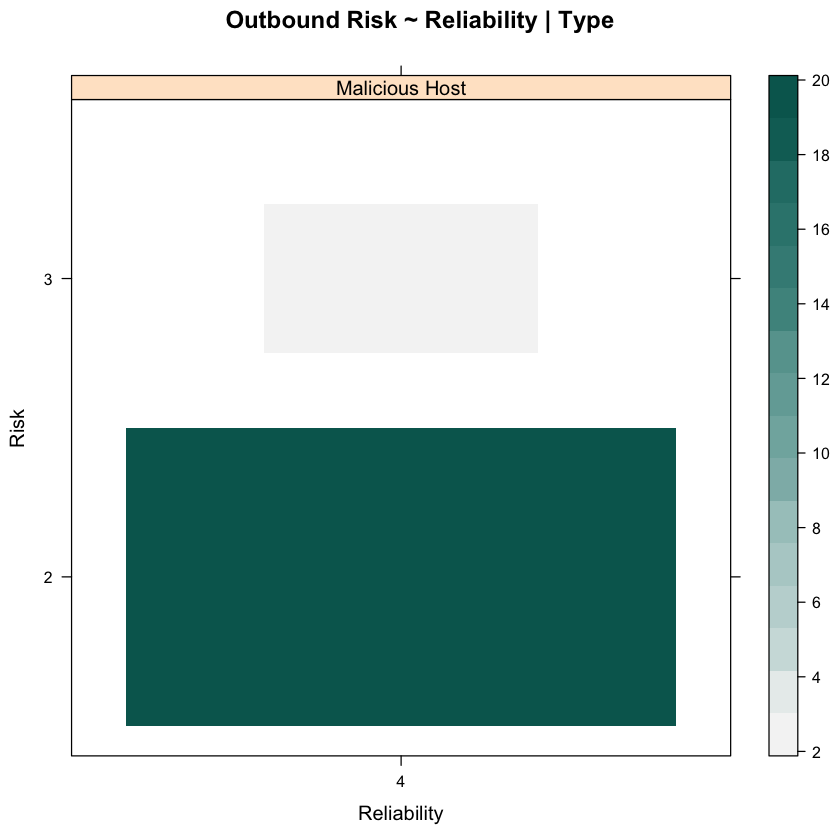

In [51]:
levelplot(Freq ~ Reliability*Risk|simpletype, data = outbound_table.df, 
         main="Outbound Risk ~ Reliability | Type", ylab = "Risk",
         xlab = "Reliability", shrink = c(0.5, 1),
         col.regions = colorRampPalette(c("#F5F5F5", "#01665E"))(20))

#### 5.2. Map areas of outbound malicious host activity

In [52]:
response_set.coords.vec <- unlist(strsplit(as.character(response_set$Coords), ","))

In [53]:
response_set.coords.mat <- matrix(response_set.coords.vec,ncol=2, byrow=TRUE)

In [54]:
response_set.coords.df <- as.data.frame(response_set.coords.mat)

In [55]:
colnames(response_set.coords.df) <- c("lat","long")

In [56]:
response_set.coords.df$long <- as.double(as.character(response_set.coords.df$long))

In [57]:
response_set.coords.df$lat <- as.double(as.character(response_set.coords.df$lat))

In [58]:
gg <- ggplot()

In [59]:
gg <- gg + geom_polygon(data = world, aes(long, lat, group=group), 
                        fill = "white")

In [60]:
gg <- gg + geom_point(data=response_set.coords.df, aes(x=long, y=lat),
                color=set2[2],size=1, alpha=0.1)

In [61]:
gg <- gg + labs(x="", y="")

In [62]:
gg <- gg + theme(panel.background = element_rect(fill = alpha(set2[3],0.4)))

#### Global distribution of outbound traffic to malicious host

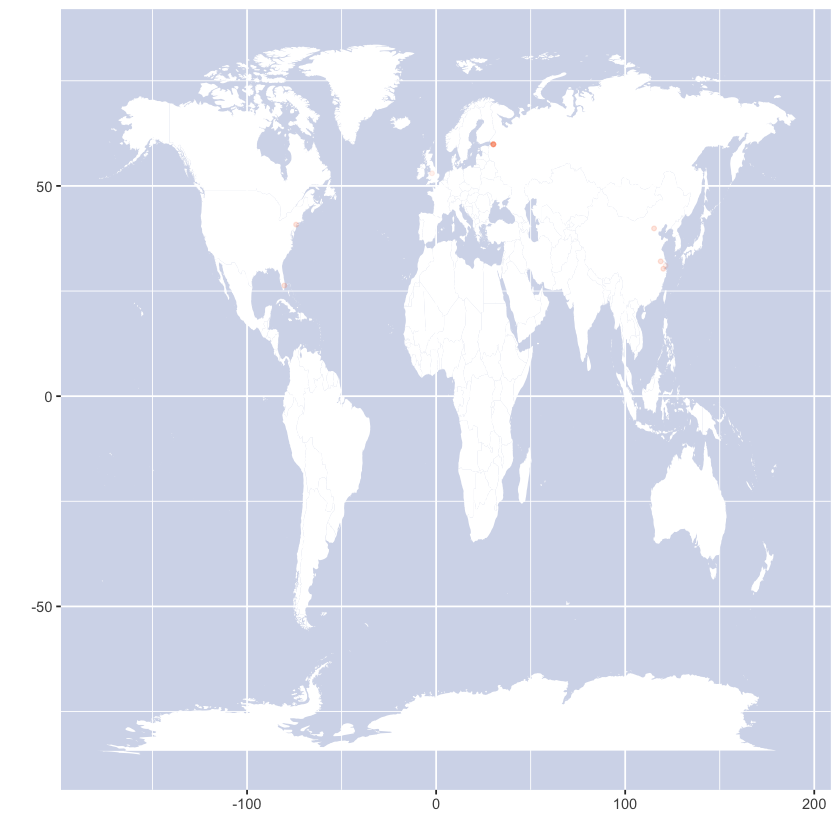

In [63]:
gg

In [72]:
# library(igraph)
# library(RColorBrewer)

### 5.3. Malicious destination by Country

In [73]:
# table(reputations[reputations$IP %in% request_set$SOURCE_IP, ]$Reliability)

In [75]:
# ips <- as.character(reputations[(reputations$IP %in% request_set$SOURCE_IP) &
#                                (reputations$Reliability > 3), ]$IP)

In [76]:
# g.cc <- graph.cc(ips,reputations)

In [85]:
write.csv(request_set, file = "request_set.csv") # Other option can be to push to SNS- Used in Lab 5

In [86]:
write.csv(response_set, file = "response_set.csv") # Other option can be to push to SNS - Used in Lab 5

In [87]:
write.csv(request_set.coords.df, file = "request_coords.csv")# Other option can be to push to SNS - Used in Lab 5